<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/NLP/TFIDF%2BN_GRAMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction

In this notebook we will work with the following configuration when doing vectorization: **TFIDF + N-grams**

The objective of this notebook is to classify the tweets *(pre-processed)* by applying various classification algorithms to the vectorized data.

## Libraries

In [13]:
import io
import pandas as pd
from google.colab import files
import re
import numpy as np
import seaborn as sns

from ast import literal_eval
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. Loading Data

We start by loading the data file that contains the preprocessing tweets with which the study will work. The file format to upload is CSV.

For this purpose, you must have the *preprocessed_data.csv* file loaded in this notebook.

In [2]:
df = pd.read_csv('./prepocessed_data.csv', sep=',')

with_e = []
without_e = []
for i in range(0,len(df)):
  without_e.append(literal_eval(df.iloc[i]['preprocessing_without_emoticons']))
  with_e.append(literal_eval(df.iloc[i]['preprocessing_with_emoticons']))

df['preprocessing_without_emoticons'] = without_e
df['preprocessing_with_emoticons'] = with_e
df = df.drop(columns=['Unnamed: 0'])
df

,preprocessing_without_emoticons,preprocessing_with_emoticons,class
0,"[woman, complain, cleaning, house, man, always...","[woman, complain, cleaning, house, man, always...",2
1,"[boy, day, cold, tea, bad, coffin, dat, st, pl...","[boy, day, cold, tea, bad, coffin, dat, st, pl...",1
2,"[dawn, ever, fuck, bitch, start, cry, confused...","[dawn, !, !, !, ever, fuck, bitch, start, cry,...",1
3,"[look, like, tranny]","[look, like, tranny]",1
4,"[shit, hear, might, true, might, baker, bitch,...","[shit, hear, might, true, might, baker, bitch,...",1
...,...,...,...
24778,"[mutual, lie, right, trash, mine, bible, scrip...","[mutual, lie, right, !, trash, mine, bible, sc...",1
24779,"[gone, broke, wrong, heart, baby, drove, redne...","[gone, broke, wrong, heart, baby, drove, redne...",2
24780,"[young, buck, anna, eat, dat, nigh, like, aunt...","[young, buck, anna, eat, !, !, dat, nigh, like...",1
24781,"[got, wild, bitch, telling, lie]","[got, wild, bitch, telling, lie]",1


# 2. Vectorization

When the tweets are preprocessed, we can start to obtain information from them.

The goal of this section is to obtain a dataframe with all the information which will be used for the next one, in order to classify the tweets.


## TFIDF + N-grams

In order to start using TFIDF, we will first have to create a TFIDFVectorizer.

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. Three steps at once. 

In addition, the N-grams will now be added to it.

In [3]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer, min_df = 3, lowercase = False, ngram_range = (1,3))
X = vectorizer.fit_transform(df['preprocessing_without_emoticons'])
X

<24783x12806 sparse matrix of type '<class 'numpy.float64'>'
	with 210169 stored elements in Compressed Sparse Row format>

# 3. Select features

We have created a new dataset where we have put the characteristics with which we will work from now on. With this dataset, feature selection will be made.

To carry out the selection of characteristics, the selectKBest function will be used. You will have to pass it the number of "top" characteristics that it will choose from the existing ones. As each column is a different word and in our problem we are asked to eliminate 70% of the words, we will only have 30% of our vocabulary.

In [4]:
# Create features and target variable for Classification problem
X_clf = X
y_clf = df['class'] # Target variable: class
n_k = round(X.shape[1] * 0.3)

best = SelectKBest(score_func = mutual_info_classif, k = n_k)

X_new = best.fit_transform(X_clf, y_clf)
print(X_new.shape)

selected = best.get_support(indices=True)
selected

(24783, 3842)


array([    0,     1,     3, ..., 12798, 12801, 12803])

# 4. Classification algorithm

## Detaching the dataset

Once we know the characteristics with which we are going to work, it is time to separate the dataset records in the training part and the test part. The test part will be made up of 30% of the tweets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_clf, test_size=0.3, random_state=0)

With the following function, we can draw the resulting confusion matrix by executing the classification algorithms.



In [6]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    
    if not title:
        if normalize: title = 'Normalized confusion matrix'
        else: title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else: print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = 'Predicted label')
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center", color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Naive Bayes algorithm

This algorithm is based on Bayes' Theorem. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

### Executing the algorithm

In [8]:
#GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
clf = BernoulliNB() # Classifier chosen
clf.fit(X_train.toarray(), y_train)
y_pred = clf.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Accuracy of the model: ', acc)

Accuracy of the model:  0.8836583725622058


### Cross validation

Now, we are going to check by cross validation that the model is correct, for this, we will make 7 splits, and we will compare the average of these with the previously obtained result, if they are similar, the model can be considered valid.

In [14]:
kf = KFold(n_splits=7)
clf = BernoulliNB()
clf.fit(X_train.toarray(), y_train) 
scores = cross_val_score(clf, X_train, y_train, cv = kf, scoring = "accuracy")
print("Accuracy of each iteration: ", scores)
print("Average: ", scores.mean())

Accuracy of each iteration:  [0.87494958 0.8846309  0.87570621 0.88902341 0.87933818 0.8882163
 0.88942696]
Average:  0.8830416476146664


### Results obtained

**Confusion Matrix**

Thanks to the following confusion matrix, we can visualize the performance of the algorithm that we have executed.

Normalized confusion matrix
[[0.27400468 0.6323185  0.09367681]
 [0.01653036 0.95510701 0.02836262]
 [0.01823949 0.21728787 0.76447264]]


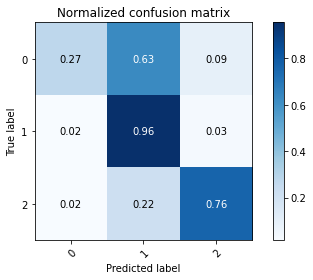

In [15]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')

**Classification Report**

Thanks to the classification of the report, we will be able to obtain more specific and interpretable information, thanks to the precision, recall, f1-score and support attributes.

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.27      0.35       427
           1       0.91      0.96      0.93      5747
           2       0.83      0.76      0.79      1261

    accuracy                           0.88      7435
   macro avg       0.74      0.66      0.69      7435
weighted avg       0.87      0.88      0.88      7435



## Random Forest

A Random Forest model is made up of a set of individual decision trees, each one trained with a random sample of the training data.

Each tree that makes up the set will predict a class, and the result of the prediction will be the class with the highest number of votes.

### Executing the algorithm

In [23]:
model = RandomForestClassifier(n_estimators = 500) # Number of trees.
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8836583725622058


### Cross validation

Now, we are going to check by cross validation that the model is correct, for this, we will make 7 splits, and we will compare the average of these with the previously obtained result, if they are similar, the model can be considered valid.

In [24]:
kf = KFold(n_splits=7)
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train.toarray(), y_train) 
scores = cross_val_score(clf, X_train, y_train, cv = kf, scoring = "accuracy")
print("Accuracy of each iteration: ", scores)
print("Average: ", scores.mean())

Accuracy of each iteration:  [0.87535296 0.88785801 0.86924939 0.89063761 0.88297014 0.89063761
 0.89305892]
Average:  0.88425209206894


### Results obtained

**Confusion Matrix**

Thanks to the following confusion matrix, we can visualize the performance of the algorithm that we have executed.

Normalized confusion matrix
[[1.61592506e-01 7.65807963e-01 7.25995316e-02]
 [7.13415695e-03 9.65199234e-01 2.76666087e-02]
 [7.93021412e-04 2.42664552e-01 7.56542427e-01]]


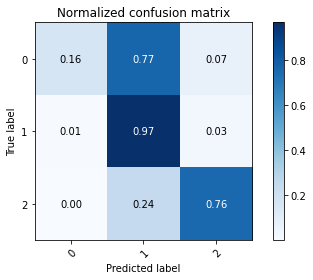

In [25]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize = True, title = 'Normalized confusion matrix')

**Classification Report**

Thanks to the classification of the report, we will be able to obtain more specific and interpretable information, thanks to the precision, recall, f1-score and support attributes.

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.16      0.26       427
           1       0.90      0.97      0.93      5747
           2       0.83      0.76      0.79      1261

    accuracy                           0.88      7435
   macro avg       0.78      0.63      0.66      7435
weighted avg       0.87      0.88      0.87      7435

